# Proyecto Modulo 5 - Modelos de agrupamiento, Evaluación de modelos y selección de modelos

**IMPORTANTE: EJECUTAR ESTE PRIMER BLOQUE DE CODIGO INDIVIDUALMENTE ANTES DE EJECUTAR EL RESTO DEL CODIGO**

## Seleccion del dataset

In [1]:
import pandas as pd
import cufflinks as cf
# from IPython.display import display
cf.set_config_file(sharing='public', theme='pearl', offline=True)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.express as px
import os
import sys
%pip install -q ipywidgets
import ipywidgets as widgets

directorio = '../Data'
# directorio = '/content'

# Leer archivos xlsx dentro de la carpeta Data
files = os.listdir(directorio)
files = [f for f in files if f.endswith('.xlsx')]

# Seleccionar archivo a leer
dropdown = widgets.Dropdown(
  options=[('Seleccionar archivo', None)] + [(f, f) for f in files],
  description='Archivo:',
  disabled=False,
)
nombre_archivo = '';
def on_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    if change['new'] is not None:
      global nombre_archivo
      global dataset
      nombre_archivo = change['new']
      print('Archivo seleccionado:', nombre_archivo)
      ruta = directorio + '/' + nombre_archivo
      print('Ruta:', ruta)
      # Leer archivo
      dataset = pd.read_excel(ruta)
      dataset.info()

dropdown.observe(on_change)
display(dropdown)


Note: you may need to restart the kernel to use updated packages.


Dropdown(description='Archivo:', options=(('Seleccionar archivo', None), ('00_df_sin_participacion.xlsx', '00_…

Archivo seleccionado: dataset_original.xlsx
Ruta: ../Data/dataset_original.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   carrera                                      1773 non-null   object 
 1   No.                                          1773 non-null   int64  
 2   Asesor                                       1773 non-null   int64  
 3   Comunidad                                    1773 non-null   object 
 4   Espacio_Académico                            1773 non-null   object 
 5   Bloque                                       1773 non-null   int64  
 6   Grupo                                        1772 non-null   object 
 7   alumnos                                      1773 non-null   int64  
 8   1er_P_Ponderación-semanas                    1773 non-null   object 

## Transfomaciones de datos

In [3]:
datos_categoricos = dataset.select_dtypes(include=['object'])
datos_numericos = dataset.select_dtypes(exclude=['object'])
datos_categoricos.info()
datos_numericos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   carrera                                   1773 non-null   object
 1   Comunidad                                 1773 non-null   object
 2   Espacio_Académico                         1773 non-null   object
 3   Grupo                                     1772 non-null   object
 4   1er_P_Ponderación-semanas                 1773 non-null   object
 5   2oP_Ponderación-semanas                   1768 non-null   object
 6   Asesoría académica Respondidas/Recibidas  1757 non-null   object
dtypes: object(7)
memory usage: 97.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                               

In [4]:
# dado que las comunidades/materias pueden tener nombres diferentes, no se consideran como variables categóricas para el análisis
# se eliminan las columnas de comunidades y materias
datos_categoricos = datos_categoricos.drop(columns=['Comunidad'])

In [5]:
# escalar los datos numéricos
scaler = StandardScaler()
datos_numericos_escalados = scaler.fit_transform(datos_numericos)
datos_numericos_escalados = pd.DataFrame(datos_numericos_escalados, columns=datos_numericos.columns)
datos_numericos_escalados.head()

,No.,Asesor,Bloque,alumnos,1p_total_actividades_asignadas,1p_total_actividades_evaluativas,1p_porcentaje_evidencias_calificadas,1p_total_actividades_calificadas,1p_total_actividades_entregadas,1p_porcentaje_evidencias_calificadas_tiempo,...,trabajos_por_calificar,Porcentaje-Eficiencia-Terminal,Aprobados,correos_enviados,correos_recibidos,Aprobados ordinario,Aprobados extraordinario,Aprobados título,Histórico de chat personal,Histórico de socializa por comunidad
0,-1.166732,0.0,-1.156803,0.745747,1.806136,1.204987,0.054428,3.183452,3.168684,0.478927,...,-0.134438,0.0,0.0,-0.432338,-0.502627,0.0,0.0,0.0,-0.079012,0.0
1,-1.147379,0.0,-1.156803,-0.099926,1.965565,1.309275,0.054428,2.226032,2.212261,0.537920,...,-0.134438,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0
2,-1.128027,0.0,-1.156803,-0.269060,2.124993,1.413563,0.054428,1.988328,1.974804,0.539886,...,-0.134438,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0
3,-1.108675,0.0,-1.156803,0.914882,2.922135,1.726426,0.054428,4.035225,4.019571,0.298017,...,-0.134438,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0
4,-1.166732,0.0,-1.156803,2.014257,2.124993,1.309275,0.054428,4.418193,4.402140,0.539886,...,-0.134438,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0


In [6]:
# codificar las variables categóricas

encoder = OneHotEncoder()
datos_categoricos_codificados = encoder.fit_transform(datos_categoricos).toarray()

# Crear nombres de características manualmente
feature_names = []
for i, column in enumerate(datos_categoricos.columns):
    feature_names.extend([f"{column}_{category}" for category in encoder.categories_[i]])

datos_categoricos_codificados = pd.DataFrame(datos_categoricos_codificados, columns=feature_names)
datos_categoricos_codificados.head()

,carrera_Ingeniería en Computación,carrera_Ingeniería en Computación (2019),carrera_Licenciado en Actuaría,carrera_Licenciado en Administración,carrera_Licenciado en Contaduría,carrera_Licenciado en Derecho 2023B,carrera_Licenciado en Derecho Internacional,carrera_Licenciado en Gastronomía,carrera_Licenciado en Gestión de la Información en Redes Sociales,carrera_Licenciado en Informática Administrativa,...,Asesoría académica Respondidas/Recibidas_2\2,Asesoría académica Respondidas/Recibidas_2\3,Asesoría académica Respondidas/Recibidas_2\4,Asesoría académica Respondidas/Recibidas_2\5,Asesoría académica Respondidas/Recibidas_3\3,Asesoría académica Respondidas/Recibidas_3\9,Asesoría académica Respondidas/Recibidas_4\12,Asesoría académica Respondidas/Recibidas_4\6,Asesoría académica Respondidas/Recibidas_7\36,Asesoría académica Respondidas/Recibidas_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelado

### Definir las funciones para los modelos

In [7]:
def input_categoricos(categoricos, numericos):
  respuesta = input("Desea usar las variables categóricas? (s/n): ")
  if respuesta == 's':
    print("Se usarán las variables categóricas, con codificación one-hot")
    return pd.concat([categoricos, numericos], axis=1)
  else:
    print("No se usarán las variables categóricas solo las numéricas")
    return numericos

In [8]:
# obtener coeficiente de silueta para determinar el número de clusters

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def test_n_clusters(data = pd.DataFrame(), type='kmeans'):
  scores = []
  range_clusters = range(2, 11)
  if type == 'kmeans':
    for n_clusters in range_clusters:
      model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
      clusters = model.fit_predict(data)
      score = silhouette_score(data, clusters)
      scores.append(score)
  else: # type == 'hierarchical'
    # probar con diferentes umbrales de 50 a 100 con brincos de 5 en 5 obtener el cluster asociado a ese umbral (si ya existe el cluster, no hacer nada)
    Z = linkage(data, method='ward')
    clusters_labels = [] # lista de clusters para cada umbral probado guardando el cluster asociado a cada observación [cluster = 1, etiquetas = DF]
    for threshold in range(35, 101, 5):
      labels = fcluster(Z, t=threshold, criterion='distance', )
      num_clusters = len(np.unique(labels))
      list_cluster = [c[0] for c in clusters_labels]
      if num_clusters not in list_cluster:
        clusters_labels.append((num_clusters, labels))
      if num_clusters == 2:
        break
    print('Clusters:', clusters_labels)

    # recorrer los clusters y obtener el coeficiente de silueta para cada uno
    for cluster_labels in clusters_labels:
      cluster, labels = cluster_labels
      score = silhouette_score(data, labels)
      scores.append(score)
    range_clusters = [c[0] for c in clusters_labels]
    range_clusters.sort()
    scores = scores[::-1]
    
  # plot scores
  plt.plot(range_clusters, scores)
  plt.xlabel('Número de clusters')
  plt.ylabel('Coeficiente de silueta')
  plt.show()
  return scores


In [9]:
def Kmeans(df):
  # Create a KMeans instance with 3 clusters: model
  inercia = []
  # Obtener gráfico de Elbow
  for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    # dont show output
    model.fit(df)
    inercia.append(model.inertia_)

  plt.plot(range(1, 11), inercia, marker='o')
  plt.xlabel('Numero de clusters')
  plt.ylabel('Inercia')
  plt.show()
  
  test_n_clusters(df)

  n_clusters = int(input("Ingrese el número de clusters: "))
  print(f"Se seleccionaron {n_clusters} clusters")
  model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
  model.fit(df)

  labels = model.predict(df)
  df_labels = df.copy()
  df_labels['cluster'] = labels
  return df_labels


In [10]:
def hierarchical_clustering(df):
  Z = linkage(df, method='ward')

  test_n_clusters(df, type='hierarchical')
  
  plt.figure(figsize=(25, 10))
  plt.title('Dendrograma jerárquico para el Clustering')
  plt.xlabel('Índices de la Muestra')
  plt.ylabel('Distancias')
  dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
  plt.show()

  threshold = int(input("Ingrese threshold para el número de clusters: "))
  print(f"Distance threshold: {threshold} ")
  # plot dendrogram
  plt.figure(figsize=(25, 10))
  plt.title('Dendrograma jerárquico para el Clustering After Cutting, threshold = {}'.format(threshold))
  plt.xlabel('Índices de la Muestra')
  plt.ylabel('Distancias')
  dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
  plt.axhline(y=threshold, c='k')
  plt.show()

  labels = fcluster(Z, t=threshold, criterion='distance')

  print(f"Se seleccionaron {len(np.unique(labels))} clusters")
  df_labeled = df.copy()
  df_labeled['cluster'] = labels
  return df_labeled

In [11]:
def PCA_clustering(df):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  finalDf = pd.concat([principalDf, df[['cluster']]], axis = 1)

  # Observar la contribución de las variables originales a cada componente principal
  print("Componentes:", pca.components_)
  print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
  fig = px.scatter(finalDf, x='principal component 1', y='principal component 2', color='cluster')
  # increase the graph size
  fig.update_layout(
    title='Clusters',
    scene=dict(
        xaxis=dict(title='PCA 1'),
        yaxis=dict(title='PCA 2'),
        # zaxis=dict(title='PCA 3')
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    height=800,
    width=800
  )
  fig.show()
  

  return finalDf

### Entrenar el modelo en base a parametros de entrada

In [12]:
def main(metodo = None): # 1: Kmeans, 2: Clustering jerárquico
  df_modelo = input_categoricos(datos_categoricos_codificados, datos_numericos_escalados)

  print("Seleccione el método de clustering a utilizar: ")
  print("1. Kmeans")
  print("2. Clustering jerárquico")
  if metodo is not None:
    print(f"Se seleccionó el método {metodo}")
  else: 
    metodo = int(input("Ingrese el número del método: "))
  
  if metodo == 1:
    df = Kmeans(df_modelo)
  elif metodo == 2:
    df = hierarchical_clustering(df_modelo)
  else:
    print("Opción no válida")
    return
  display(df)
  PCA_clustering(df)
  return df


No se usarán las variables categóricas solo las numéricas
Seleccione el método de clustering a utilizar: 
1. Kmeans
2. Clustering jerárquico
Se seleccionó el método 1


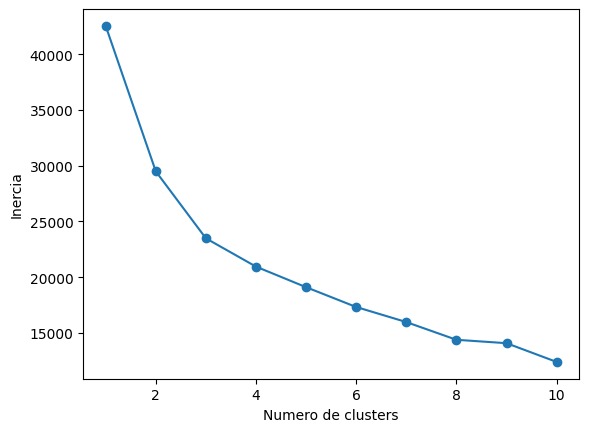

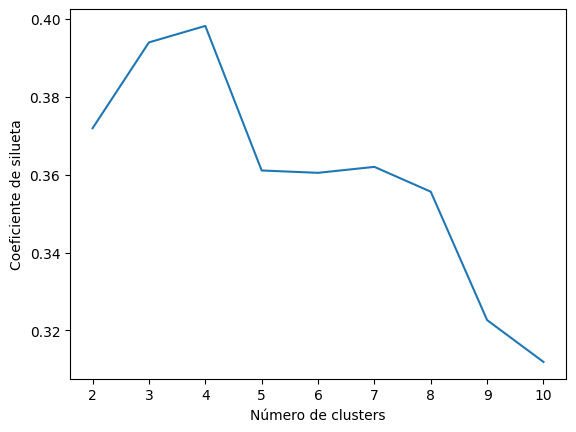

Se seleccionaron 3 clusters


,No.,Asesor,Bloque,alumnos,1p_total_actividades_asignadas,1p_total_actividades_evaluativas,1p_porcentaje_evidencias_calificadas,1p_total_actividades_calificadas,1p_total_actividades_entregadas,1p_porcentaje_evidencias_calificadas_tiempo,...,Porcentaje-Eficiencia-Terminal,Aprobados,correos_enviados,correos_recibidos,Aprobados ordinario,Aprobados extraordinario,Aprobados título,Histórico de chat personal,Histórico de socializa por comunidad,cluster
0,-1.166732,0.0,-1.156803,0.745747,1.806136,1.204987,0.054428,3.183452,3.168684,0.478927,...,0.0,0.0,-0.432338,-0.502627,0.0,0.0,0.0,-0.079012,0.0,2
1,-1.147379,0.0,-1.156803,-0.099926,1.965565,1.309275,0.054428,2.226032,2.212261,0.537920,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
2,-1.128027,0.0,-1.156803,-0.269060,2.124993,1.413563,0.054428,1.988328,1.974804,0.539886,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
3,-1.108675,0.0,-1.156803,0.914882,2.922135,1.726426,0.054428,4.035225,4.019571,0.298017,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
4,-1.166732,0.0,-1.156803,2.014257,2.124993,1.309275,0.054428,4.418193,4.402140,0.539886,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,-0.470052,0.0,-0.016719,1.760555,0.690137,0.162108,0.053859,1.215789,1.209665,-0.048073,...,0.0,0.0,-0.432338,-0.502627,0.0,0.0,0.0,-0.079012,0.0,0
1769,-0.450700,0.0,-1.156803,1.591420,-0.904147,-0.567907,-0.134981,-0.666036,-0.676797,-0.443323,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,0
1770,-0.431348,0.0,-1.156803,1.253151,-0.904147,-0.567907,-0.134981,-0.666036,-0.676797,-0.443323,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,0
1771,-0.411996,0.0,-1.156803,2.098824,-0.904147,-0.567907,-0.134981,-0.666036,-0.676797,-0.443323,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,0


Componentes: [[-3.84655673e-02  2.22044605e-16 -1.36983941e-02 -3.77547285e-02
   2.70466083e-01  1.75357464e-01  1.81813704e-02  2.67995794e-01
   2.66573610e-01  1.07171247e-01  2.58993609e-01  1.81243536e-01
   2.68890778e-01  2.75993755e-01  2.33618355e-01  2.74769304e-01
   2.73944212e-01  2.28656513e-01  2.62758038e-01  1.81172559e-01
   2.75439085e-01 -1.28129812e-02  0.00000000e+00  0.00000000e+00
   1.12821310e-01  1.26462277e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.97533451e-03  0.00000000e+00  1.60828373e-01]
 [ 1.20183861e-01  0.00000000e+00 -2.27470748e-01  4.11013574e-01
  -2.21997348e-02 -2.18288547e-02 -2.40446151e-02  2.09034696e-01
   2.16113199e-01 -1.04776279e-01  2.15889140e-01 -3.39325455e-01
  -5.60309572e-02 -5.39600860e-02 -2.45931896e-01  1.71102599e-01
   1.76726691e-01 -1.95876437e-01  1.86618692e-01 -3.37994303e-01
   1.95095242e-01  6.76237311e-02 -3.53681685e-27  1.74840436e-27
  -2.38507969e-01 -2.79972069e-01  0.00000000e+00  0.00000000e

In [13]:
df_kmeans = main(1)

No se usarán las variables categóricas solo las numéricas
Seleccione el método de clustering a utilizar: 
1. Kmeans
2. Clustering jerárquico
Se seleccionó el método 2
Clusters: [(11, array([4, 4, 4, ..., 2, 2, 2], dtype=int32)), (9, array([4, 4, 4, ..., 2, 2, 2], dtype=int32)), (8, array([4, 4, 4, ..., 2, 2, 2], dtype=int32)), (7, array([3, 3, 3, ..., 1, 1, 1], dtype=int32)), (6, array([2, 2, 2, ..., 1, 1, 1], dtype=int32)), (4, array([2, 2, 2, ..., 1, 1, 1], dtype=int32)), (3, array([2, 2, 2, ..., 1, 1, 1], dtype=int32))]


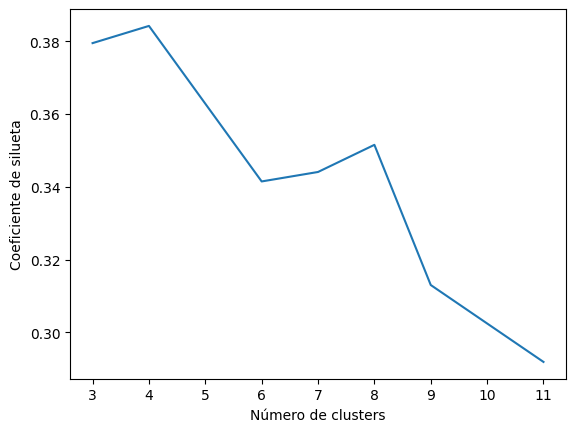

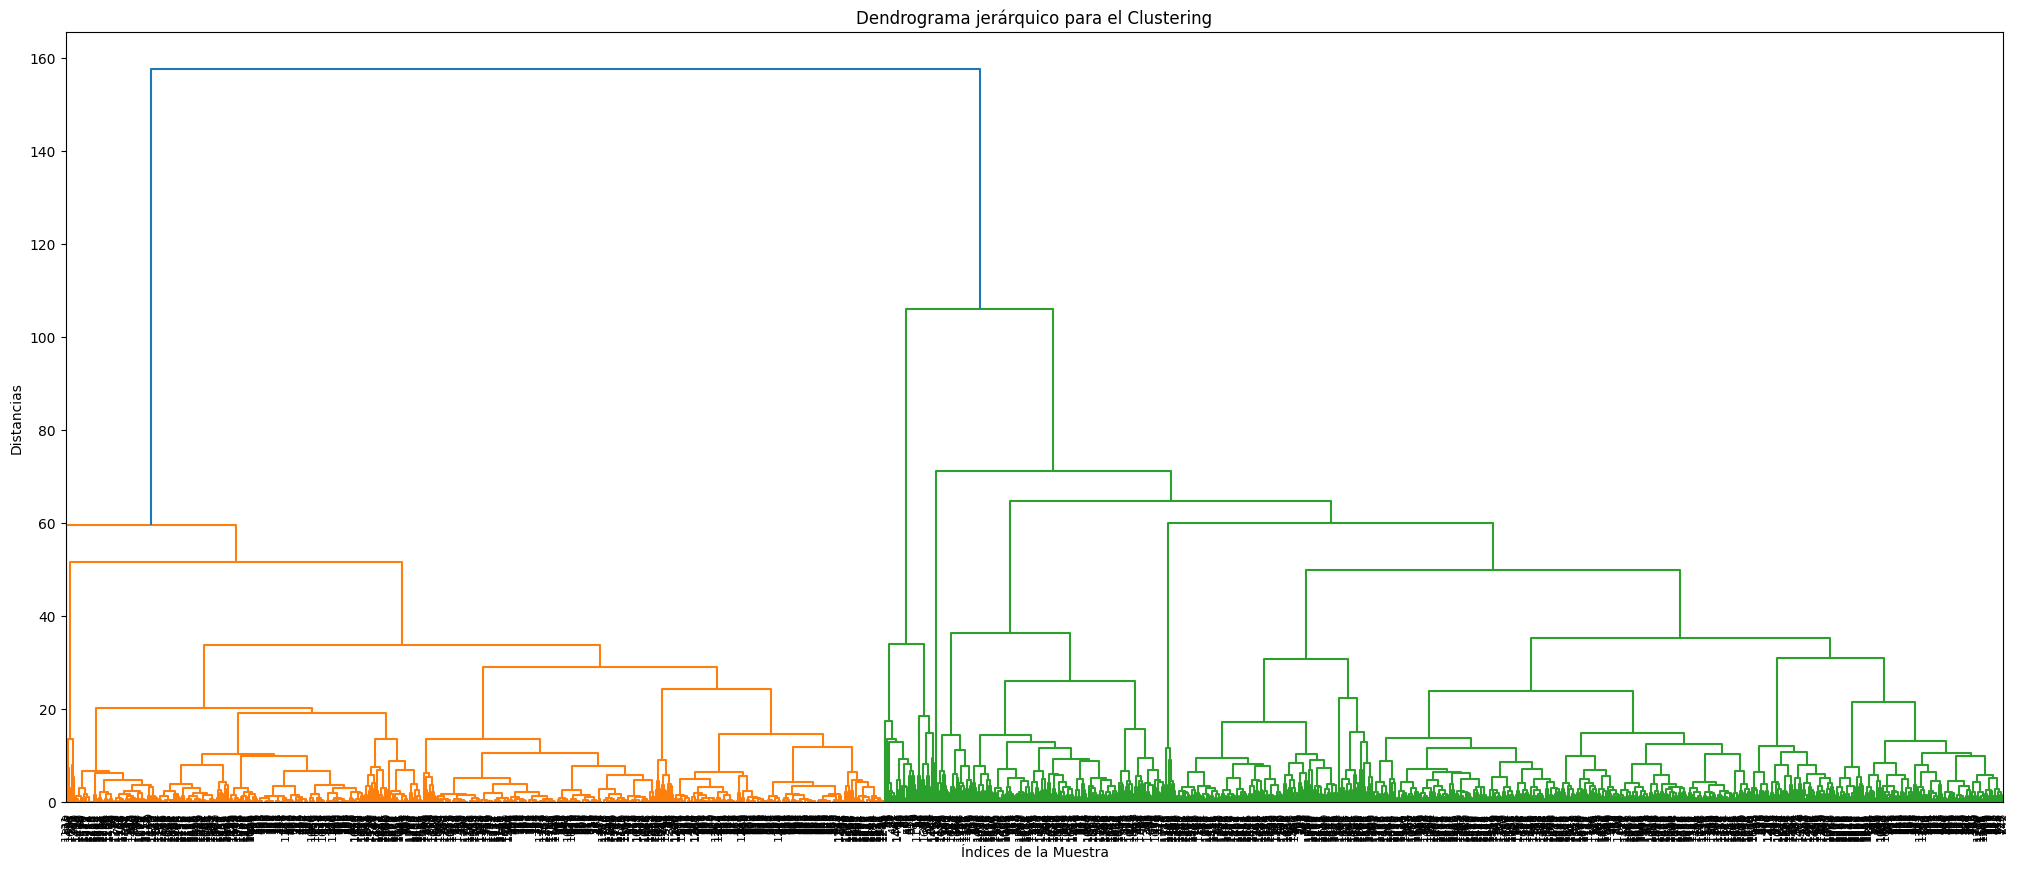

Distance threshold: 80 


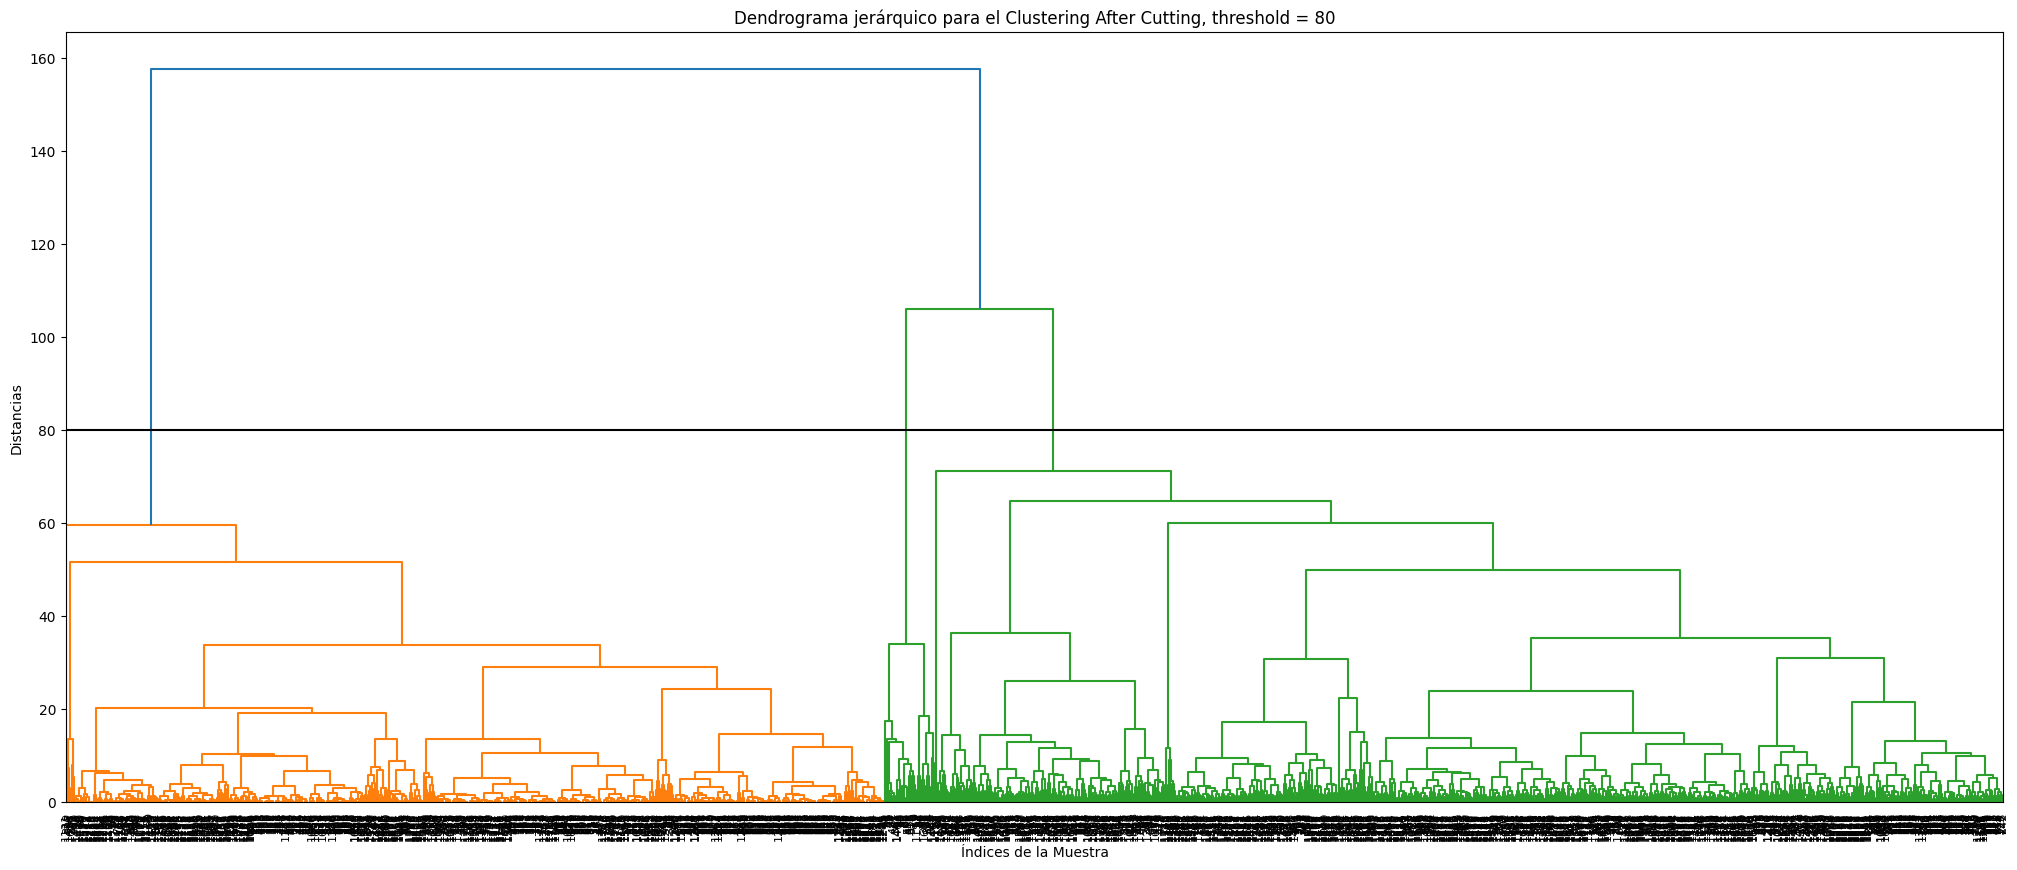

Se seleccionaron 3 clusters


,No.,Asesor,Bloque,alumnos,1p_total_actividades_asignadas,1p_total_actividades_evaluativas,1p_porcentaje_evidencias_calificadas,1p_total_actividades_calificadas,1p_total_actividades_entregadas,1p_porcentaje_evidencias_calificadas_tiempo,...,Porcentaje-Eficiencia-Terminal,Aprobados,correos_enviados,correos_recibidos,Aprobados ordinario,Aprobados extraordinario,Aprobados título,Histórico de chat personal,Histórico de socializa por comunidad,cluster
0,-1.166732,0.0,-1.156803,0.745747,1.806136,1.204987,0.054428,3.183452,3.168684,0.478927,...,0.0,0.0,-0.432338,-0.502627,0.0,0.0,0.0,-0.079012,0.0,2
1,-1.147379,0.0,-1.156803,-0.099926,1.965565,1.309275,0.054428,2.226032,2.212261,0.537920,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
2,-1.128027,0.0,-1.156803,-0.269060,2.124993,1.413563,0.054428,1.988328,1.974804,0.539886,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
3,-1.108675,0.0,-1.156803,0.914882,2.922135,1.726426,0.054428,4.035225,4.019571,0.298017,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
4,-1.166732,0.0,-1.156803,2.014257,2.124993,1.309275,0.054428,4.418193,4.402140,0.539886,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,-0.470052,0.0,-0.016719,1.760555,0.690137,0.162108,0.053859,1.215789,1.209665,-0.048073,...,0.0,0.0,-0.432338,-0.502627,0.0,0.0,0.0,-0.079012,0.0,1
1769,-0.450700,0.0,-1.156803,1.591420,-0.904147,-0.567907,-0.134981,-0.666036,-0.676797,-0.443323,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,1
1770,-0.431348,0.0,-1.156803,1.253151,-0.904147,-0.567907,-0.134981,-0.666036,-0.676797,-0.443323,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,1
1771,-0.411996,0.0,-1.156803,2.098824,-0.904147,-0.567907,-0.134981,-0.666036,-0.676797,-0.443323,...,0.0,0.0,-0.432338,-0.590132,0.0,0.0,0.0,-0.079012,0.0,1


Componentes: [[-3.87353602e-02  0.00000000e+00 -1.00296399e-02 -4.39048855e-02
   2.67816031e-01  1.73598540e-01  1.83643596e-02  2.61307262e-01
   2.59706554e-01  1.08079812e-01  2.51426654e-01  1.87973133e-01
   2.66672586e-01  2.73975553e-01  2.38505051e-01  2.68737093e-01
   2.67770929e-01  2.31021165e-01  2.55613683e-01  1.87792718e-01
   2.69143781e-01 -1.45808204e-02  0.00000000e+00  0.00000000e+00
   1.14592539e-01  1.29531546e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.27422755e-03  0.00000000e+00  2.11634213e-01]
 [ 1.00270116e-01 -2.77555756e-16 -2.12676331e-01  3.81374637e-01
   1.38454406e-03 -3.36468120e-03 -2.04657198e-02  2.18661030e-01
   2.25664165e-01 -8.97866757e-02  2.29035220e-01 -3.22974127e-01
  -3.00814555e-02 -2.95354620e-02 -2.32496380e-01  1.82415645e-01
   1.88140137e-01 -1.75662270e-01  2.01685227e-01 -3.21700592e-01
   2.04771271e-01  6.81934092e-02 -1.13913436e-29  3.70719502e-31
  -2.05274419e-01 -2.48106120e-01 -0.00000000e+00 -0.00000000e

In [17]:
df_hc = main(2)

## Salida de resultados

In [15]:
# insertar los clusters en el dataset original
dataset_salida = dataset.copy()
dataset_salida['cluster_kmeans'] = df_kmeans['cluster']
dataset_salida['cluster_hc'] = df_hc['cluster']

# el cluster de kmeans dio clusters del 0 al 2, mientras que el de clustering jerárquico dio clusters del 1 al 3
# convertir los clusters de clustering kmeans a 1, 2 y 3
dataset_salida['cluster_kmeans'] = dataset_salida['cluster_kmeans'].apply(lambda x: x+1)

In [16]:
# input del el nombre del archivo sin extensión y sin espacios, pero si puede tener guiones si no cumple con un formato válido continuará pidiendo el nombre

nombre_archivo = '  '

def nombre_valido(nombre):
  # si contiene espacios retorna False
  if ' ' in nombre:
    return False
  nombre_normalizado = nombre.replace('-', '').replace('_', '')
  sigue_alfanumerico = nombre_normalizado.isalnum()
  print(f"nombre: {nombre}, nombre_normalizado: {nombre_normalizado}, sigue_alfanumerico: {sigue_alfanumerico}")
  return sigue_alfanumerico

while not nombre_valido(nombre_archivo):
  nombre_archivo = input("Ingrese el nombre del archivo de salida sin extensión y sin espacios: ")

directorio_salida = '../Results'
# directorio_salida = '/content'

if not os.path.exists(directorio_salida):
  os.makedirs(directorio_salida)

dataset_salida.to_excel(f'{directorio_salida}/{nombre_archivo}.xlsx', index=False)

nombre: , nombre_normalizado: , sigue_alfanumerico: False
nombre: , nombre_normalizado: , sigue_alfanumerico: False
nombre: , nombre_normalizado: , sigue_alfanumerico: False
nombre: a, nombre_normalizado: a, sigue_alfanumerico: True
